In [5]:
from ultralytics import YOLO
import numpy as np
import os
import polars as pl
from ultralytics import settings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ultralytics.utils.plotting import Annotator

# Update a setting
settings.update({'mlflow': True})

model = YOLO("runs/detect/train42/weights/best.pt")


0: 640x448 (no detections), 30.1ms
Speed: 1.9ms preprocess, 30.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)


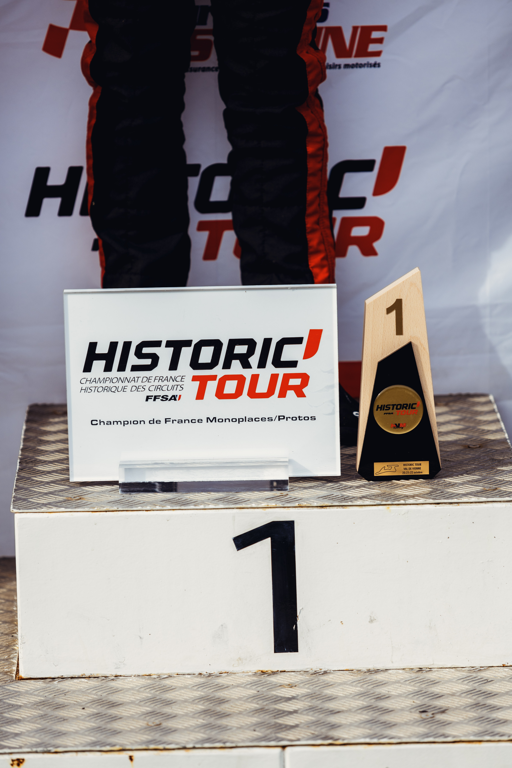


0: 448x640 3 cars, 29.6ms
Speed: 1.8ms preprocess, 29.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


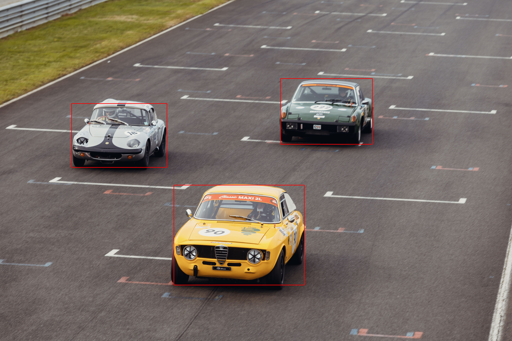


0: 448x640 1 car, 33.5ms
Speed: 2.2ms preprocess, 33.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


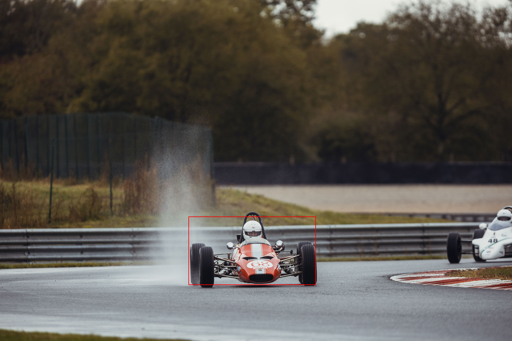


0: 448x640 1 car, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


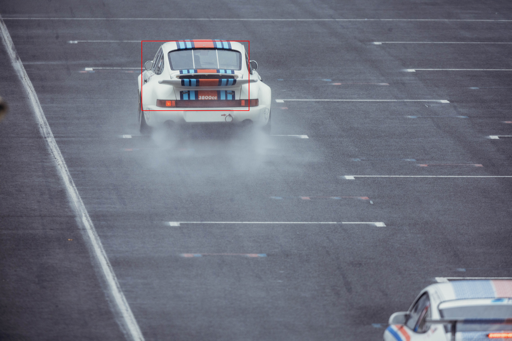

In [16]:
for image_path in os.listdir("test_images/"):
    image_path = os.path.join("test_images/", image_path)
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    
    # Perform object detection
    results = model(img)
    
    # Iterate through the results and draw bounding boxes
    for result in results:
        for box in result.boxes:
            left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=int).squeeze()
            width = right - left
            height = bottom - top
            center = (left + int((right-left)/2), top + int((bottom-top)/2))
            label = results[0].names[int(box.cls)]
            confidence = float(box.conf.cpu())
        
            cv2.rectangle(img_np, (left, top), (right, bottom), (255, 0, 0), 5)
            # cv2.putText(img_np, label, (left, bottom+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)
        
    # Display the image with bounding boxes
    img = Image.fromarray(img_np)
    img = img.resize((512, int(img.height // (img.width / 512))))
    display(img)